In [1]:
setwd("/home/huaqingj/MyResearch/TVDN/")

In [3]:
library(fda)
library(MASS)
library(glmnet)
library(mvtnorm)
library(R.matlab)

In [4]:
set.seed(2021) ##6chg6rank 2021

In [5]:
fMRI = readMat('./data/fMRI_sample.mat')
fMRI = fMRI$time.series

In [6]:
d <- dim(fMRI)[1]
n <- dim(fMRI)[2]
time = seq(0, 2, length.out = n)
step = diff(time)[1]
nI = 20

### B-spline

In [7]:
dfMRI = matrix(NA, ncol=180, nrow=90)
for(i in 1:nrow(fMRI)){
    dfMRI[i, ]= predict(smooth.spline(time, fMRI[i, ], lambda = 0.001), deriv = 1)$y
}
dXmat = dfMRI
Xmat = fMRI

In [8]:
scan = rep(0, length(time))
for(i in nI:(length(time) - nI)){
    ix1 = (i - nI + 1) : i
    ix2 = ( i + 1) : (i + nI)
    ix = (i-nI + 1) : (i + nI)
    fullA = dXmat[, ix] %*% t(Xmat[, ix] ) %*% ginv(Xmat[, ix] %*% t(Xmat[, ix]) )
    leftA = dXmat[, ix1] %*% t(Xmat[, ix1] ) %*% ginv(Xmat[, ix1] %*% t(Xmat[, ix1]))
    rightA = dXmat[, ix2] %*% t(Xmat[, ix2] ) %*% ginv(Xmat[, ix2] %*% t(Xmat[, ix2]))
    temp = as.vector(dXmat[, ix] - fullA %*% Xmat[, ix])
    ssRfull = t(temp) %*% temp
    temp = as.vector(dXmat[, ix1] - leftA %*% Xmat[, ix1])
    ssRleft = t(temp) %*% temp
    temp = as.vector(dXmat[, ix2] - rightA %*% Xmat[, ix2])
    ssRright = t(temp) %*% temp
    scan[i]= ssRfull - ssRleft - ssRright
}


In [9]:
candlist = NULL
for(i in nI:(length(time) - nI)){
    if(scan[i] == max(scan[(i - nI + 1): (i + nI)]) & scan[i] > min(scan[(i - nI + 1): (i + nI)]))
        candlist = c(candlist, i)
}
candlist = c(0, candlist, length(time))


In [10]:
fullA = array(NA, c(nrow(fMRI), nrow(fMRI), length(candlist)-1))
for(j in 1:(length(candlist) -1)){
    left = candlist[j] + 1
    right = candlist[j + 1]
    ix = left:right
    fullA[, , j]= dXmat[, ix] %*% t(Xmat[, ix] ) %*% ginv(Xmat[, ix] %*% t(Xmat[, ix]))
}


### Some tuning parameters

In [139]:
nsim = 50
lenSeq = 180

r = 6
candlist0 =c(0, 30, 110, 150, lenSeq) # change point set
ratio = seq(-7, 8, length.out = 12)

### Make `AA` low rank

In [140]:
AA = apply(fullA, c(1, 2), sum)
svdRes = svd(AA)
AA = svdRes$u[, 1:r] %*% diag(svdRes$d[1:r]) %*% t(svdRes$v[, 1:r])

### The eigenvectors and eigenvalues for each segment

In [141]:
temp = eigen(AA)
U = temp$vector
V = temp$values 

# The true change points
svdA = matrix(NA, nrow(Xmat),  length(candlist0)-1)
for(j in 1:(length(candlist0)-1)){
    svdA[, j]= V * ratio[j]/10
    }

svdA[(r + 1):nrow(svdA), ] = 0

Res <- list()
Res[[1]] <- U
Res[[2]] <- svdA

## Generate datasets

In [142]:
U <- Res[[1]]
svdA <- Res[[2]]
invU <- solve(U)

In [143]:
time = seq(0, 2, length.out = lenSeq)
step = diff(time)[1]

truematrix = datamatrix = vector('list')
errV =  U %*% diag(svdA[, 1]/10) %*%invU * matrix(rbinom(90 *90, 1, 0.1), 90, 90)
Xmat =Xmat1=  dXmat1 = dXmat = matrix(NA, nrow(dfMRI), length(time))
Xmat1[, 1] <- matrix(rnorm(nrow(Xmat), 0, (step)/8), nrow(Xmat),1)

### Generate the data for `nsim` times

In [144]:
errDen <- 16
for(itr in 1:nsim){
    Xmat[, 1] = Xmat1[, 1] +  errV %*% matrix(rnorm(nrow(Xmat), 0, (step)/errDen), nrow(Xmat),1)
    k = 1
    dXmat1[, 1] = U %*% diag(svdA[, 1]) %*%invU%*% Xmat1[, 1] * step
    for(j in 2:length(time)){
        if(j %in% candlist0 & j != length(time)){
            k = k + 1
        }
        Xmat1[, j]= Xmat1[, j-1] + dXmat1[, j-1]
        Xmat[, j] = Xmat1[, j] +  errV %*%  matrix(rnorm(nrow(Xmat), 0, (step)/errDen), nrow(Xmat),1)
        dXmat1[, j] = U [,1:r]%*% diag(svdA[1:r, k] * step) %*% invU[1:r, ]%*% Xmat1[, j]
    }
    Xmat = Re(Xmat)
    datamatrix[[itr]]= Re(Xmat)
    truematrix[[itr]] = Re(Xmat1)
}

### A demo plot

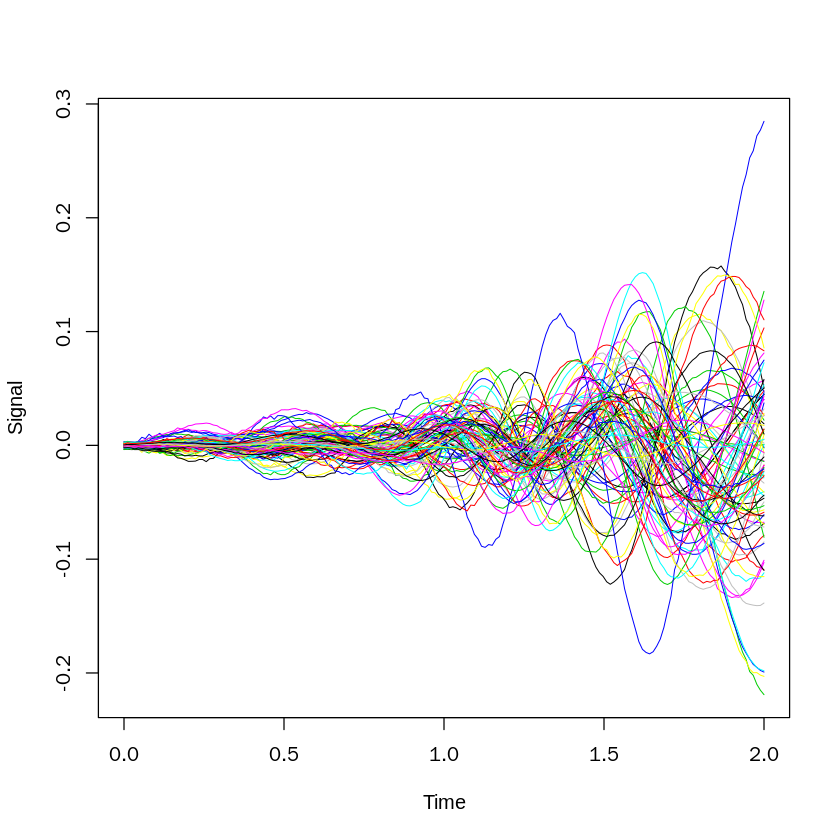

In [145]:
Xmat <- datamatrix[[10]]
#Xmat <- truematrix[[10]]
plot(Xmat[1, ]~time, col = 1, type = 'l', lwd = 0.8, ylab = 'Signal', xlab = 'Time', ylim = range(Xmat), xlim = range(time))
for(i in 1:90){
        lines (Xmat[i, ]~time, col = i, lwd = 0.8, ylab = 'Signal', xlab = 'Time')
}

In [146]:
savef <- paste0("./NeuroImgR1/data/dataMat2_Nsim", nsim, "_Chg", length(candlist0)-2, "_rank", r, "_len", lenSeq, ".RData")
save(datamatrix, truematrix, candlist0,  U, file = savef)